In [1]:
import qctoolkit as qtk
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import horton as ht
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import UnivariateSpline
from glob import glob
import os
import itertools

#Note inline and notebook is contradicting to each other
%matplotlib notebook

/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


missing file: mov2asc
please modify /path/to/qctoolkit/setting.py and recompile.


# N2 3D surface with finite difference data

In [2]:
# qmjob settings

qmsetting_test = {
    'program': 'horton',
    'basis_set': 'sto-3g',
    'theory': 'pbe',
    'threads': 1,
}

qmsetting_production = {
    'program': 'gaussian',
    'basis_set': 'cc-pVDZ',
    'theory': 'pbe',
    'threads': 1,
}

qmsetting_production_ccsd = {
    'program': 'gaussian',
    'basis_set': 'cc-pVDZ',
    'theory': 'ccsd',
    'threads': 1,
}

qmsetting_production_ccsdt = {
    'program': 'gaussian',
    'basis_set': 'cc-pVDZ',
    'theory': 'ccsd(t)',
    'threads': 1,
}

qmsetting_hf_d2E = {
    'program': 'gaussian',
    'basis_set': 'cc-pVDZ',
    'theory': 'hf',
    'threads': 1,
}

with open('ccpvdz_ar_gbasis.txt') as f:
    ar_basis = f.readlines()
    
with open('ccpvdz_ne_gbasis.txt') as f:
    ne_basis = f.readlines()
    
qmsetting_pbe_same_basis = {
    'program': 'gaussian',
    #'basis_set': ar_basis, gaussian failed too many simple basis function?
    'basis_set': ne_basis,
    'theory': 'pbe',
    'threads': 1,
}

In [4]:
def FD_diff_ZZR(qmsetting, base=[7,7,1.1], dz=0.05, dr=0.00529, get_mols=False):
    dZ = [-dz, 0, dz]
    dR = [-dr, 0, dr]
    mols = []
    inps = []
    for dz1, dz2, dr in itertools.product(dZ, dZ, dR):
        i, j, k = dZ.index(dz1), dZ.index(dz2), dR.index(dr)
        mol = qtk.Molecule()
        mol.build([[base[0],0,0,0], [base[1],base[2]+dr,0,0]])
        new_Z = mol.Z + np.array([dz1, dz2])
        mol.name = 'diff_' + mol.name + '_%d%d%d' % (i,j,k)
        if (base[0] + base[1]) % 2 != 0:
            mol.setChargeMultiplicity(0, 2)
        inp = qtk.QMInp(mol, nuclear_charges=new_Z, **qmsetting)
        inps.append(inp)
        mols.append(mol)
    if get_mols:
        return inps, mols
    else:
        return inps

In [5]:
def FD_diff_ZZR_largedZ(qmsetting, base=[7,7,1.1], dr=0.00529, get_mols=False):
    dZ = [-1, 0, 1]
    dR = [-dr, 0, dr]
    mols = []
    inps = []
    for dz1, dz2, dr in itertools.product(dZ, dZ, dR):
        i, j, k = dZ.index(dz1), dZ.index(dz2), dR.index(dr)
        mol = qtk.Molecule()
        mol.build([[base[0],0,0,0], [base[1],base[2]+dr,0,0]])
        new_Z = mol.Z + np.array([dz1, dz2])
        mol.setAtoms(0, Z=new_Z[0])
        mol.setAtoms(1, Z=new_Z[1])
        mol.name = 'diff_' + mol.name + '_%d%d%d' % (i,j,k)
        if (mol.Z[0] + mol.Z[1]) % 2 != 0:
            mol.setChargeMultiplicity(0, 2)
        inp = qtk.QMInp(mol, nuclear_charges=new_Z, **qmsetting)
        inps.append(inp)
        mols.append(mol)
    if get_mols:
        return inps, mols
    else:
        return inps

In [6]:
def surface_N2_ZZR(qmsetting, Z_A=range(1,14), Z_B=range(1,14), R=np.arange(0.7, 5.1, 0.2), 
                   neutral=True, get_mols=False, cutZ=None):
    if cutZ is not None:
        Z_A, Z_B = Z_A[cutZ:-cutZ], Z_B[cutZ:-cutZ]
    mols = []
    inps = []
    for Z1 in Z_A:
        for Z2 in Z_B:
            for d in R:
                # choose d ~ N2 bond length of 1.0975
                #d = 1.1
                mol = qtk.Molecule()
                mol.build([[Z1,0,0,0], [Z2,d,0,0]])
                if not neutral:
                    mol.name = mol.name + '_c'
                mol.name = 'surf_' + mol.name + '_%02d_%02d_%3.1f' % (Z1, Z2, d)
                if neutral:
                    if (Z1 + Z2) % 2 == 1:
                        mol.setChargeMultiplicity(0, 2)
                else:
                    mol.charge = Z1 + Z2 - 14
                inp = qtk.QMInp(mol, save_chk=False, **qmsetting)
                inps.append(inp)
                mols.append(mol)
    if get_mols:
        return inps, mols
    else:
        return inps

In [6]:
inps_N2_3D_large = surface_N2_ZZR(qmsetting_production)

In [81]:
qtk.qmWriteAll(inps_N2_3D_large, 'gaussian_N2_pbe_large', compress=True)

In [6]:
small_range = R=np.arange(0.6, 2.1, 0.1)
inps_N2_3D_small = surface_N2_ZZR(qmsetting_production, R=small_range, cutZ=3)
inps_N2_3D_small_charged = surface_N2_ZZR(qmsetting_production, R=small_range, cutZ=3, neutral=False)
inps_diff_N2 = FD_diff_ZZR(base=[7,7,1.1])
inps_diff_CO = FD_diff_ZZR(base=[6,8,1.1])
inps_diff_BF = FD_diff_ZZR(base=[5,9,1.1])

In [7]:
inps_all = []
for inps in [inps_N2_3D_small, inps_N2_3D_small_charged, inps_diff_N2, inps_diff_CO, inps_diff_BF]:
    inps_all.extend(inps)
len(inps_all)

1551

In [7]:
small_range = R=np.arange(0.6, 2.1, 0.1)
inps_N2_3D_small = surface_N2_ZZR(qmsetting_production, R=small_range)
inps_N2_3D_small_charged = surface_N2_ZZR(qmsetting_production, R=small_range, neutral=False)
inps_diff = []
for Z1 in range(1,8)[::-1]:
    for Z2 in range(7,14):
        inps_diff.extend(FD_diff_ZZR(base=[Z1,Z2,1.1]))

In [8]:
inps_all = []
for inps in [inps_N2_3D_small, inps_N2_3D_small_charged, inps_diff]:
    inps_all.extend(inps)
len(inps_all)

6393

In [9]:
inps_diff = []
for dz in range(7):
    inps_diff.extend(FD_diff_ZZR_largedZ(qmsetting_production, base=[7-dz,7+dz,1.1]))

In [28]:
inps_diff = []
for dz in range(7):
    inps_diff.extend(FD_diff_ZZR(qmsetting_production, base=[7-dz,7+dz,1.1], dz=0.3))

In [29]:
len(inps_diff)

189

In [30]:
qtk.qmWriteAll(inps_diff, 'gaussian_diff_dZ03', compress=True)

In [9]:
qtk.qmWriteAll(inps_all, 'gaussian_N2_pbe_H2', compress=True)

qmWriteAll: compression completed 


In [7]:
small_range = R=np.arange(0.9, 1.4, 0.1)
inps_N2_3D_small = surface_N2_ZZR(qmsetting_pbe_same_basis, R=small_range)
#inps_N2_3D_small_charged = surface_N2_ZZR(R=small_range, neutral=False)
inps_diff = []
inps_diff = []
for dz in range(7):
    inps_diff.extend(FD_diff_ZZR(qmsetting_pbe_same_basis, base=[7-dz,7+dz,1.1], dz=0.05))
inps_all = []
for inps in [inps_N2_3D_small, inps_diff]:
    inps_all.extend(inps)
len(inps_all)

1034

In [8]:
qtk.qmWriteAll(inps_all, 'gaussian_pbe_same_basis_Ne', compress=True)

qmWriteAll: compression completed 


# data extraction

In [9]:
def get_surf_ZZR(name_root, prefix=None, ext='log', quite=True, get_outarr=False, 
                 except_pattern=None, include_pattern=None):
    
    if prefix is None:
        f_list = sorted(glob(os.path.join('%s' % name_root, '*', '*.%s' % ext)))
    else:
        f_list = sorted(glob(os.path.join('%s' % name_root, '%s*' % prefix, '*.%s' % ext)))
        if except_pattern:
            f_list = filter(lambda x: except_pattern not in x, f_list)
        if include_pattern:
            f_list = filter(lambda x: include_pattern in x, f_list)
            
    
    outs = []
    for f in f_list:
        outs.append(qtk.QMOut(f, program='gaussian'))
        
    Z_As = []
    Z_Bs = []
    Rs = []
    
    for out in outs:
        #i,j,k = map(int, list(os.path.splitext(out.name)[0].split('_')[1]))
        za, zb, r = [float(s) for s in os.path.splitext(out.name)[0].split('_')[-3:]]
        r = r * qtk.setting.a2b # convert from angrstrom to bohr
        Z_As.append(za)
        Z_Bs.append(zb)
        Rs.append(r) 
    
    Z_A_full = sorted(set(Z_As))
    Z_B_full = sorted(set(Z_Bs))
    dR_full = sorted(set(Rs))
        
    E = np.zeros([len(Z_A_full), len(Z_B_full), len(dR_full)])
    out_arr = np.zeros(E.shape, dtype=object)
    X_list = []
    E_list = []
    for s, out in enumerate(outs):
        n = [Z_As[s], Z_Bs[s], Rs[s]]
        i,j,k = [np.argmin(abs(np.array(arr) - n[i])) for i, arr in enumerate([Z_A_full, Z_B_full, dR_full])]
        E[i,j,k] = out.Et - out.nuclear_repulsion
        E_list.append(E[i,j,k])
        X_list.append([Z_A_full[i], Z_B_full[j], dR_full[k]])
        out_arr[i,j,k] = out.name
        #print i,j,k, os.path.splitext(out.name)[0], out.energies
        #E[i,j,k] = out.Et - out.nuclear_repulsion
    X_list = np.array(X_list)
    E_list = np.array(E_list)

    #np.savez('data_N2_3D_ZZR_pbe.npz', E=E_list, X=X_list, axes=['Z1', 'Z2', 'R'])
    
    return E_list, X_list

In [10]:
E_list, X_list = get_surf_ZZR('old/N2_full_3DSurface', ext='log')
print E_list[:3]
print X_list[:3, :]
print E_list.shape, X_list.shape

something wrong when accessing final energy with error message: list index out of range
old/N2_full_3DSurface/C1Ne1_10_06_1.33/C1Ne1_10_06_1.33.log failed with message: local variable 'rmsd' referenced before assignment
[-90.20123236 -84.4807881  -80.80553964]
[[5.         6.         0.94486299]
 [5.         6.         1.26611641]
 [5.         6.         1.56847257]]
(490,) (490, 3)


In [11]:
E_list, X_list = get_surf_ZZR('old/gaussian_N2_pbe', 'surf_', ext='log', except_pattern='_c_')
print E_list[:3]
print X_list[:3, :]
print E_list.shape, X_list.shape

something wrong when accessing final energy with error message: list index out of range
old/gaussian_N2_pbe/surf_C1F1_09_06_1.8/surf_C1F1_09_06_1.8.log failed with message: local variable 'rmsd' referenced before assignment
something wrong when accessing final energy with error message: list index out of range
old/gaussian_N2_pbe/surf_N1F1_07_09_1.4/surf_N1F1_07_09_1.4.log failed with message: local variable 'rmsd' referenced before assignment
something wrong when accessing final energy with error message: list index out of range
old/gaussian_N2_pbe/surf_N1Ne1_07_10_1.4/surf_N1Ne1_07_10_1.4.log failed with message: local variable 'rmsd' referenced before assignment
[-86.44646745 -83.62612423 -81.43773701]
[[5.         6.         1.13383559]
 [5.         6.         1.32280819]
 [5.         6.         1.51178079]]
(735,) (735, 3)


In [12]:
E_list, X_list = get_surf_ZZR('old/gaussian_N2_pbe', 'surf_', ext='log', include_pattern='_c_')
print E_list[:3]
print X_list[:3, :]
print E_list.shape, X_list.shape

something wrong when accessing final energy with error message: list index out of range
old/gaussian_N2_pbe/surf_Be2_c_04_04_0.5/surf_Be2_c_04_04_0.5.log failed with message: local variable 'rmsd' referenced before assignment
[-89.14352026 -85.42005425 -82.73845723]
[[5.         6.         0.94486299]
 [5.         6.         1.13383559]
 [5.         6.         1.32280819]]
(784,) (784, 3)


In [13]:
def get_diff_ZZR(name_root, mol_flag=None, prefix='diff_', ext='log', quite=True, get_outarr=False):
    
    if mol_flag is None:
        f_list = sorted(glob('%s/*/*.%s' % (name_root, ext)))
    else:
        f_list = sorted(glob('%s/%s%s*/*.%s' % (name_root, prefix, mol_flag, ext)))
    
    if quite:
        qtk.setting.quiet=True
    outs = []
    for f in f_list:
        outs.append(qtk.QMOut(f, program='gaussian'))
    qtk.setting.quite=False
    
    E = np.zeros([3,3,3])
    out_arr = np.zeros([3,3,3], dtype=object)
    for out in outs:
        if mol_flag is None:
            i,j,k = map(int, list(os.path.splitext(out.name)[0].split('_')[1]))
        else:
            i,j,k = map(int, list(os.path.splitext(out.name)[0].split(mol_flag)[-1].split('_')[1]))
        #print i,j,k, os.path.splitext(out.name)[0], out.energies
        E[i,j,k] = out.Et - out.nuclear_repulsion
        out_arr[i,j,k] = out
    if get_outarr:
        return E, out_arr
    else:
        return E

In [14]:
def diff2_3D(E, dx):
    """compute gradiant vector and hessian matrix
       e.g. E: shape (3, 3, 3, 3), dx: shape (4, )
       out: g: shape (4, ), hessian: shape(4, 4)
       expect E with 3 points for each dimension
    """
    
    def f2i(ind):
        """convert np array to int tuple for indexing"""
        return tuple(ind.astype(int).tolist())
    
    i0 = np.ones(len(dx))
    g = np.zeros(len(dx))
    h = np.zeros([len(dx), len(dx)])
    for i in range(len(dx)):
        ind_p = i0.copy()
        ind_m = i0.copy()
        ind_p[i] += 1
        ind_m[i] -= 1 
        dE_xi = (E[f2i(ind_p)] - E[f2i(ind_m)]) / (2 * dx[i])
        g[i] = dE_xi
        
        for j in range(i, len(dx)):
            if i == j:
                dE_xixj = (E[f2i(ind_p)] - 2 * E[f2i(i0)] + E[f2i(ind_m)]) / (dx[i] ** 2)
            else:
                ind_pp = ind_p.copy()
                ind_pp[j] += 1
                ind_pm = ind_p.copy()
                ind_pm[j] -= 1
                ind_mp = ind_m.copy()
                ind_mp[j] += 1
                ind_mm = ind_m.copy()
                ind_mm[j] -= 1
                
                dE_xixj = (
                    (E[f2i(ind_pp)] - E[f2i(ind_pm)]) / (2 * dx[i]) - \
                    (E[f2i(ind_mp)] - E[f2i(ind_mm)]) / (2 * dx[i])
                ) / (2 * dx[j])
            
            h[i,j] = h[j,i] = dE_xixj
    return g, h

In [15]:
def diff_dN(out_arr, dx, base=[1,1,1], method='c'):
    
    b1, b2, b3 = base
    out = out_arr[tuple(base)]
    homo_i = out.molecule.ne() / 2 - 1
    lumo_i = homo_i + 1
    
    def get_ew(out, ew_ind=homo_i):
        return out.mo_eigenvalues[ew_ind]
    
    
    E_homo = np.zeros([3,3,3])
    E_lumo = np.zeros([3,3,3])
    
    for d1 in [-1,0,1]:
        i = d1 + 1
        for d2 in [-1,0,1]:
            j = d2 + 1
            for d3 in [-1,0,1]:
                k = d3 + 1
                out = out_arr[b1+d1, b2+d2, b3+d3]
                
                try:
                    E_homo[i,j,k] = out.mo_eigenvalues[homo_i]
                    E_lumo[i,j,k] = out.mo_eigenvalues[lumo_i]
                except:
                    print "failed for %d,%d,%d" % (i,j,k)
                    E_homo[i,j,k] = np.nan
                    E_lumo[i,j,k] = np.nan
    
    E_dN = (E_homo + E_lumo) / 2
    
    if method == 'c':
        dNz1 = (E_dN[b1+1,b2,b3] - E_dN[b1-1,b2,b3]) / (2*dx[0])
        dNz2 = (E_dN[b1,b2+1,b3] - E_dN[b1,b2-1,b3]) / (2*dx[1])
        dNr  = (E_dN[b1,b2,b3+1] - E_dN[b1,b2,b3-1]) / (2*dx[2])
    elif method == 'f':
        dNz1 = (E_dN[b1+1,b2,b3] - E_dN[b1,b2,b3]) / (dx[0])
        dNz2 = (E_dN[b1,b2+1,b3] - E_dN[b1,b2,b3]) / (dx[1])
        dNr  = (E_dN[b1,b2,b3+1] - E_dN[b1,b2,b3]) / (dx[2])
    elif method == 'b':
        dNz1 = (E_dN[b1,b2,b3] - E_dN[b1-1,b2,b3]) / (dx[0])
        dNz2 = (E_dN[b1,b2,b3] - E_dN[b1,b2-1,b3]) / (dx[1])
        dNr  = (E_dN[b1,b2,b3] - E_dN[b1,b2,b3-1]) / (dx[2])
    
    dNN = (E_lumo[1,1,1] - E_homo[1,1,1]) / 2
    
    return E_dN[tuple(base)], np.array([dNz1, dNz2, dNr, dNN])

## Gaussian to horton conversion for analytic first order derivative

In [60]:
data_root = 'gaussian_pbe_same_basis'
fd_dx = [.05, .05, 0.01] # in Bohr!
#E, outarr = get_diff_ZZR(data_root, 'HAl', 'diff_', 'log', quite=True, get_outarr=True)
E, outarr = get_diff_ZZR(data_root, 'HeMg', 'diff_', 'log', quite=True, get_outarr=True)

In [61]:
E

array([[[-210.65495114, -210.6038711 , -210.55318684],
        [-212.65828954, -212.6100714 , -212.55932614],
        [-214.67787224, -214.6266725 , -214.57586784]],

       [[-210.83435424, -210.7833519 , -210.73274354],
        [-212.83919014, -212.7881272 , -212.73745814],
        [-214.85442104, -214.8032992 , -214.75093744]],

       [[-211.01841474, -210.9674897 , -210.91639314],
        [-213.02182114, -212.9708358 , -212.92024274],
        [-215.03561894, -214.9845751 , -214.93392364]]])

In [62]:
def get_htarr(outarr, run=False, run_all=False):
    htarr = []
    for out in outarr.ravel():
        if run or run_all:
            hto = out.as_horton(reinitialize=True, theory='pbe')
        else:
            hto = out.as_horton()

        if not run_all:
            Ek = hto.e_kin() 
            Ev = hto.e_ext()
            dEk = abs(Ek - out.energies['Ekin'])
            dEv = abs(Ev - out.energies['Eext'])
            if dEk > 1E-5 or dEv > 1E-5:
                diff = True
                print "%s %3.2f %3.2f %s" % (out.name, dEk, dEv, "E_kin and E_ext mismatched")

                if run:
                    try:
                        hto.run()
                        print "%s %3.2f %3.2f" % (out.name, out.Et, hto.Et)
                    except:
                        try:
                            hto.initialize()
                            hto.run()
                            print "%s g09:%3.2f horton:%3.2f initial run failed" % (out.name, out.Et, hto.Et),
                            print " %3.2f %3.2f" % (Ek, hto.e_kin())
                        except Exception as err:
                            print "rerun failed with err: %s" % str(err)
        else:
            hto.initialize()
            print "%s " % out.name,
            hto.run()
            dE = abs(out.Et - hto.Et)
            print "g09:%3.2f horton:%3.2f, dE:%7.1E" % (out.Et, hto.Et, dE)
        htarr.append(hto)
    return np.array(htarr).reshape(outarr.shape)
htarr = get_htarr(outarr)

diff_HeMg_000.log 4.77 18.25 E_kin and E_ext mismatched
diff_HeMg_001.log 4.76 18.24 E_kin and E_ext mismatched
diff_HeMg_002.log 4.76 18.22 E_kin and E_ext mismatched
diff_HeMg_010.log 4.74 18.43 E_kin and E_ext mismatched
diff_HeMg_011.log 4.79 18.37 E_kin and E_ext mismatched
diff_HeMg_012.log 4.79 18.35 E_kin and E_ext mismatched
diff_HeMg_100.log 4.72 18.23 E_kin and E_ext mismatched
diff_HeMg_101.log 4.71 18.21 E_kin and E_ext mismatched
diff_HeMg_102.log 4.71 18.20 E_kin and E_ext mismatched


In [63]:
def get_ht_d1Earr(htarr, dz1=-1, dz2=1):
    d1E = []
    for hto in htarr.ravel():
        R = hto.molecule.R.tolist()
        dZ = np.array([dz1, dz2])
        ZR = np.hstack([dZ[:, np.newaxis], R])
        dV_ao = hto.dV_ao_ZRCoords(ZR)
        d1E.append(hto.d1E(dV_ao))
    return np.asarray(d1E).reshape(htarr.shape)

def get_ht_d1E_zz(htarr):
    d1E_z1 = get_ht_d1Earr(htarr, 1,0)
    d1E_z2 = get_ht_d1Earr(htarr, 0,1)
    return d1E_z1[1,1,1], d1E_z2[1,1,1]

d1E_z1 = get_ht_d1Earr(htarr, 1,0)
d1E_z2 = get_ht_d1Earr(htarr, 0,1)

In [103]:
d1E_z1

array([[[-8.21984176, -8.19406569, -8.16853625],
        [-8.21574204, -8.19773357, -8.17215422],
        [-9.31003766, -9.2835373 , -9.25727409]],

       [[-8.29989288, -8.27409742, -8.24854827],
        [-9.40658334, -9.38018719, -9.35402833],
        [-9.40213148, -9.37562562, -9.36739241]],

       [[-9.50500743, -9.47871621, -9.46337594],
        [-9.50053761, -9.4741365 , -9.4479763 ],
        [-9.49600118, -9.46949294, -9.44322889]]])

In [104]:
d1E_z2

array([[[-39.61590918, -39.61130308, -39.60672597],
        [-39.81279007, -39.81278994, -39.80818828],
        [-41.37977488, -41.37406724, -41.3683991 ]],

       [[-39.6199719 , -39.61530286, -39.61066339],
        [-41.16749137, -41.16163939, -41.15582888],
        [-41.37531752, -41.36949991, -41.35942645]],

       [[-40.95512985, -40.94913051, -40.94049081],
        [-41.16303541, -41.15707291, -41.15115548],
        [-41.37078762, -41.3648614 , -41.35898076]]])

In [68]:
def get_ht_d2E_zz(htarr, dx, method='f'):
    b1, b2, b3 = [1,1,1]
    if method == 'f':
        c1, c2, c3 = [1,1,1]
        factor = 1.
    elif method == 'c':
        c1, c2, c3 = [0,0,0]
        factor = 2.
    
    d1E_z1 = get_ht_d1Earr(htarr, 1,0)
    d1E_z2 = get_ht_d1Earr(htarr, 0,1)
    
    dE_z1z1 = (d1E_z1[ 2, b2, b3] - d1E_z1[c1, b2, b3]) / (factor * dx[0])
    dE_z1z2 = (d1E_z1[b1,  2, b3] - d1E_z1[b1, c2, b3]) / (factor * dx[1])
    dE_z2z2 = (d1E_z2[b1,  2, b3] - d1E_z2[b1, c2, b3]) / (factor * dx[1])
    dE_z2z1 = (d1E_z2[ 2, b2, b3] - d1E_z2[c1, b2, b3]) / (factor * dx[0])
    dE_mix = (dE_z1z2 + dE_z2z1) / 2.
    
    d2E = np.array([
        [dE_z1z1, dE_mix ],
        [dE_mix , dE_z2z2]
    ])
    return d2E

In [101]:
print d1E_z1[1,1,1]
print d1E_z2[1,1,1]
get_ht_d2E_zz(htarr, fd_dx)

-9.380187185910446
-41.16163938700751


array([[-1.87898637,  0.09128037],
       [ 0.09128037, -4.15721042]])

## final wrapper

In [21]:
def grad_pad_4D(g, h, dN, dN2):
    g_4D = np.hstack([g, dN])
    h_1 = np.vstack([h, dN2[:3]])
    h_4D = np.hstack([h_1, dN2[:, np.newaxis]])
    return g_4D, h_4D

In [22]:
def grad_4D(name_root, dx, mol_flag=None, prefix='diff_', ext='log', method='c', horton=False, run=False):
    """wrapper for getting 4D derivatives from file"""
    E, out_arr = get_diff_ZZR(name_root, mol_flag, prefix, ext, quite=True, get_outarr=True)
    g, h = diff2_3D(E, dx)
    if horton:
        htarr = get_htarr(out_arr, run=run)
        g_ht = get_ht_d1E_zz(htarr)
        h_ht = get_ht_d2E_zz(htarr, dx, method=method)
        g[:2] = g_ht
        h[:2, :2] = h_ht
    gN, hN = diff_dN(out_arr, dx, method=method)
    return grad_pad_4D(g, h, gN, hN)

## interface test

In [23]:
def test_old_data_files():
    dx_test = [0.05, 0.05, 0.1]
    E_N2, out_arr_N2 = get_diff_ZZR('old/N2_3D_diff_production', ext='out', get_outarr=True)
    g_N2, h_N2 = diff2_3D(E_N2, dx_test)
    g_dN, h_dN = diff_dN(out_arr_N2, dx_test, method='f')
    g4, h4 = grad_pad_4D(g_N2, h_N2, g_dN, h_dN)
    print g4
    print h4

    dx_test = [0.05, 0.05, 0.1]
    g4, h4 = grad_4D('old/N2_3D_diff_production', dx_test, ext='out', method='f')
    print g4
    print h4
    w, v = np.linalg.eigh(h4)
    print v
    
def test_combined_format():
    fd_dx = [0.05, 0.05, 0.01] # in Bohr!
    E_N2, out_arr_N2 = get_diff_ZZR('old/gaussian_N2_pbe', 'N2', get_outarr=True)
    g_N2, h_N2 = diff2_3D(E_N2, fd_dx)
    g_N2_dN, h_N2_dN = diff_dN(out_arr_N2, fd_dx)
    g_N2_4D, h_N2_4D = grad_pad_4D(g_N2, h_N2, g_N2_dN, h_N2_dN)
    print g_N2_4D
    print h_N2_4D

    g4, h4 = grad_4D('old/gaussian_N2_pbe', fd_dx, 'N2')
    print g4
    print h4
    
test_old_data_files()
test_combined_format()

failed for 0,1,1
[-18.287127   -18.287127    21.44825495  -0.20629954]
[[ -1.87756      0.50777      0.279875    -0.47285301]
 [  0.50777     -1.87756      0.279875    -0.47285301]
 [  0.279875     0.279875   -33.19024899  -0.19919472]
 [ -0.47285301  -0.47285301  -0.19919472   0.15230449]]
failed for 0,1,1
[-18.287127   -18.287127    21.44825495  -0.20629954]
[[ -1.87756      0.50777      0.279875    -0.47285301]
 [  0.50777     -1.87756      0.279875    -0.47285301]
 [  0.279875     0.279875   -33.19024899  -0.19919472]
 [ -0.47285301  -0.47285301  -0.19919472   0.15230449]]
[[-8.70790178e-03  7.07106781e-01  6.61253824e-01 -2.50334881e-01]
 [-8.70790178e-03 -7.07106781e-01  6.61253824e-01 -2.50334881e-01]
 [ 9.99907777e-01  5.55111512e-17  9.48961975e-03 -9.71519173e-03]
 [ 5.72562018e-03  8.88178420e-16  3.54113975e-01  9.35184747e-01]]
[-18.287127   -18.287127    11.31072856  -0.20629954]
[[-1.87756     0.50777     0.14875    -0.47163264]
 [ 0.50777    -1.87756     0.14875    -0.4

## derivative data

In [70]:
#data_root = 'gaussian_N2_pbe'
# g_N2, h_N2 = grad_4D(data_root, fd_dx, 'N2')
# g_CO, h_CO = grad_4D(data_root, fd_dx, 'C1O1') # note: generated name comes with number
# g_BF, h_BF = grad_4D(data_root, fd_dx, 'B1F1')
#data_root = 'gaussian_N2_pbe_H-Al'
#data_root = 'gaussian_diff_largedZ'
#data_root = 'gaussian_diff_dZ03'
data_root = 'gaussian_pbe_same_basis'
fd_dx = [.05, .05, 0.01] # in Bohr!

#sys = ['N2', 'C1O1', 'B1F1', 'Be1Ne1', 'Li1Na1', 'He1Mg1', 'H1Al1']
sys = ['N2', 'CO', 'BF', 'BeNe', 'LiNa', 'HeMg', 'HAl']

print "finite difference with: ", str(fd_dx)
print 'data folder:', data_root

g_list, h_list = [], []
for s in sys:
    g, h = grad_4D(data_root, fd_dx, s, horton=True, method='f')
    g_list.append(g)
    h_list.append(h)
g_list = np.asarray(g_list)
h_list = np.asarray(h_list)

finite difference with:  [0.05, 0.05, 0.01]
data folder: gaussian_pbe_same_basis
diff_N2_000.log 4.56 20.36 E_kin and E_ext mismatched
diff_N2_001.log 4.55 20.33 E_kin and E_ext mismatched
diff_N2_002.log 4.55 20.31 E_kin and E_ext mismatched
diff_N2_010.log 4.60 20.50 E_kin and E_ext mismatched
diff_N2_011.log 4.59 20.47 E_kin and E_ext mismatched
diff_N2_012.log 4.59 20.45 E_kin and E_ext mismatched
diff_N2_100.log 4.60 20.50 E_kin and E_ext mismatched
diff_N2_101.log 4.59 20.47 E_kin and E_ext mismatched
diff_N2_102.log 4.59 20.45 E_kin and E_ext mismatched
diff_CO_000.log 4.09 17.94 E_kin and E_ext mismatched
diff_CO_001.log 4.09 17.93 E_kin and E_ext mismatched
diff_CO_002.log 4.10 17.93 E_kin and E_ext mismatched
diff_CO_010.log 4.11 18.01 E_kin and E_ext mismatched
diff_CO_011.log 4.12 18.00 E_kin and E_ext mismatched
diff_CO_012.log 4.12 17.99 E_kin and E_ext mismatched
diff_CO_100.log 4.14 18.15 E_kin and E_ext mismatched
diff_CO_101.log 4.15 18.15 E_kin and E_ext mismatched
d

In [94]:
np.round(g_list, decimals=1)

array([[-21.9, -21.9,  11.4,  -0.1],
       [-18.8, -25.3,  11.1,   0. ],
       [-16.2, -29. ,  10.1,   0.2],
       [-13.6, -33. ,   4.6,   0.4],
       [-11.5, -37. ,   7. ,   0.6],
       [ -9.4, -41.2,   5.1,   0.6],
       [ -7.8, -45.5,   2.7,   0.5]])

In [72]:
np.round(g_list, decimals=1)

array([[-21.9, -21.9,  11.4,  -0.1],
       [-18.8, -25.3,  11.1,   0. ],
       [-16.2, -29. ,  10.1,   0.2],
       [-13.6, -33. ,   4.6,   0.4],
       [-11.5, -37. ,   7. ,   0.6],
       [ -9.4, -41.2,   5.1,   0.6],
       [ -7.8, -45.5,   2.7,   0.5]])

In [88]:
h_list[3:][0,0]

array([-2.22410625e+00, -4.48294114e-03, -3.30261500e+01, -6.94468140e-01])

In [100]:
np.round(h_list[-4:,:2,:2], decimals=1)

array([[[-2.2, -0. ],
        [-0. , -3.9]],

       [[-2.1,  0. ],
        [ 0. , -4.1]],

       [[-1.9,  0.1],
        [ 0.1, -4.2]],

       [[-1. , -0.9],
        [-0.9, -2. ]]])

In [92]:
h_list[-1]

array([[-1.00121342e+00, -9.05374249e-01,  6.27239500e+01,
        -4.32196450e-01],
       [-9.05374249e-01, -2.01823195e+00,  9.25000001e-03,
        -1.66671995e+00],
       [ 6.27239500e+01,  9.25000001e-03, -2.05374347e+00,
         4.78075000e-03],
       [-4.32196450e-01, -1.66671995e+00,  4.78075000e-03,
        -1.79942550e-02]])

In [93]:
np.savez('gaussian_pbe_same_basis.npz', 
         g_list=g_list, h_list=h_list,
         dx=fd_dx,
        )

In [37]:
h_list

array([[[-1.87977333e+00,  5.08799444e-01,  1.47625000e-01,
         -4.72113259e-01],
        [ 5.08799444e-01, -1.87977333e+00,  1.47625000e-01,
         -4.72113262e-01],
        [ 1.47625000e-01,  1.47625000e-01, -9.28987925e+00,
         -1.18003620e-01],
        [-4.72113259e-01, -4.72113262e-01, -1.18003620e-01,
          1.52304489e-01]],

       [[-1.52117889e+00,  4.90504444e-01,  1.91991667e-01,
         -4.82141320e-01],
        [ 4.90504444e-01, -2.27099222e+00,  4.69416667e-02,
         -4.13897489e-01],
        [ 1.91991667e-01,  4.69416667e-02, -9.11951437e+00,
         -1.36085442e-01],
        [-4.82141320e-01, -4.13897489e-01, -1.36085442e-01,
          1.34473760e-01]],

       [[-1.30407222e+00,  4.36179167e-01,  1.52800000e-01,
         -4.26641306e-01],
        [ 4.36179167e-01, -2.51670111e+00, -6.62166667e-02,
         -3.41968328e-01],
        [ 1.52800000e-01, -6.62166667e-02, -8.49141972e+00,
         -8.99909625e-02],
        [-4.26641306e-01, -3.41968328e-

## 3D surface scan

In [41]:
E_N2_small_neutral, X_N2_small_neutral = get_surf_ZZR(data_root, 'surf_', ext='log', except_pattern='_c_')
E_N2_small_charged, X_N2_small_charged = get_surf_ZZR(data_root, 'surf_', ext='log', include_pattern='_c_')

In [42]:
E_N2_small_neutral.shape

(2535,)

In [43]:
E_N2_small_charged.shape

(2535,)

In [45]:
np.savez('gaussian_N2_pbe_H-Al.npz', 
         E_neutral=E_N2_small_neutral, X_neutral=X_N2_small_neutral,
         E_charged=E_N2_small_charged, X_charged=X_N2_small_charged,
         g_list=g_list, h_list=h_list,
#          g_N2=g_N2, g_CO=g_CO, g_BF=g_BF,
#          h_N2=h_N2, h_CO=h_CO, h_BF=h_BF,
         dx=fd_dx,
        )

# N2 ZR crossection (old)

## input generation

In [3]:
# construct dataset ZR

Z_A = range(1, 14)
Z_B = deepcopy(Z_A)
Z_B.reverse()

mols = []
inps = []
for i in range(len(Z_A)):
    Z1, Z2 = Z_A[i], Z_B[i]
    #print "processing (%d, %d)" % (Z1, Z2)
    for d in np.linspace(0.5, 2, 10):
        mol = qtk.Molecule()
        mol.build([[Z1,0,0,0], [Z2,d,0,0]])
        mol.name = mol.name + '_%02d_%4.2f' % (Z1, d)
        # construct horton input object 
        # and compute AO integrals for initialization
        job = qtk.QMInp(mol, **qmsetting_production_ccsdt)
        mols.append(mol)
        inps.append(job)
print "all done"

all done


## output extraction

In [4]:
# save data into numpy format
outs = []
for f in sorted(glob('N2_RZ_production_ccsdt_run/*/*.out')):
    outs.append(qtk.QMOut(f, program='gaussian'))

dZ = []
E = []
for out in outs:
    #_, Z1, Z2 = os.path.splitext(out.name)[0].split('_')
    Z1, d = out.molecule.Z[0], out.molecule.R[1][0]
    dZ.append([int(Z1) - 7, d])
    E.append(out.Et - out.nuclear_repulsion)
dZ = np.array(dZ)
E = np.array(E)
np.savez('data_N2_RZ_ccsdt.npz', E=E, X=dZ, axes=['dZ1', 'R'])

# N2 ZZ crossection

## input generation

In [46]:
range(1, 14)[0:-(0+1)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [7]:
# construct dataset Z
cut = 3
ref_d = 1.1
Z_A_full = range(1, 14)[cut:-cut]
Z_B_full = deepcopy(Z_A_full)
Z_B_full.reverse()

mols_full = []
inps_full = []
for Z1 in Z_A_full:
    for Z2 in Z_B_full:
        #print "processing (%d, %d)" % (Z1, Z2)
        # choose d ~ N2 bond length of 1.0975
        #d = 1.1
        d = ref_d
        mol = qtk.Molecule()
        mol.build([[Z1,0,0,0], [Z2,d,0,0]])
        mol.name = mol.name + '_%02d_%02d' % (Z1, Z2)
        # construct horton input object 
        # and compute AO integrals for initialization
        #mol.charge = Z1 + Z2 - 14
        if (Z1 + Z2) % 2 == 1:
            mol.setChargeMultiplicity(0, 2)
        #job = qtk.QMInp(mol, **qmsetting_test)
        #job = qtk.QMInp(mol, **qmsetting_production)
        job = qtk.QMInp(mol, **qmsetting_production_ccsdt)
        inps_full.append(job)
        mols_full.append(mol)
print "all done"

all done


In [5]:
#qtk.qmWriteAll(inps_full, 'N2_production_ccsdt_wocharge_run', compress=True)

## output extraction

In [9]:
# # convert molecule data to unified interface
# # HORTON

# dZ = []
# E = []
# for mol in mols_full:
#     x, y, z = mol.molecule.Z[0] - 7, mol.molecule.Z[1] - 7, mol.Et - mol.nn
#     dZ.append([x, y])
#     E.append(z)

# dZ = np.array(dZ)
# E = np.array(E)
# np.savez('data_N2_sto3g.npz', X=dZ, E=E, axes=['dZ1', 'dZ2'])

In [10]:
from glob import glob
import os

outs = []
for f in sorted(glob('N2_production_ccsdt_wocharge_run/*/*.out')):
    outs.append(qtk.QMOut(f, program='gaussian'))

dZ = []
E = []
for out in outs:
    _, Z1, Z2 = os.path.splitext(out.name)[0].split('_')
    dZ.append([int(Z1) - 7, int(Z2) - 7])
    E.append(out.Et - out.nuclear_repulsion)
dZ = np.array(dZ)
E = np.array(E)
np.savez('data_N2_ccsdt_wocharge.npz', E=E, X=dZ, axes=['dZ1', 'dZ2'])

# N2 3D surface (Z1, Z2, R)

## input generation

In [12]:
cut = 3
ref_d = 1.1
Z_A_full = range(1, 14)[cut:-cut]
Z_B_full = deepcopy(Z_A_full)
Z_B_full.reverse()
dR_full = np.linspace(0.5, 2, 10)

mols_full = []
inps_full = []
for Z1 in Z_A_full:
    for Z2 in Z_B_full:
        for d in dR_full:
            #print "processing (%d, %d)" % (Z1, Z2)
            # choose d ~ N2 bond length of 1.0975
            #d = 1.1
            mol = qtk.Molecule()
            mol.build([[Z1,0,0,0], [Z2,d,0,0]])
            mol.name = mol.name + '_%02d_%02d_%4.2f' % (Z1, Z2, d)
            # construct horton input object 
            # and compute AO integrals for initialization
            #mol.charge = Z1 + Z2 - 14
            if (Z1 + Z2) % 2 == 1:
                mol.setChargeMultiplicity(0, 2)
            #job = qtk.QMInp(mol, **qmsetting_test)
            job = qtk.QMInp(mol, **qmsetting_production)
            #job = qtk.QMInp(mol, **qmsetting_production_ccsdt)
            inps_full.append(job)
            mols_full.append(mol)
print "all done"

all done


In [7]:
#qtk.qmWriteAll(inps_full, 'N2_full_3DSurface', compress=True)

## output extraction

In [13]:
outs = []
for f in sorted(glob('N2_full_3DSurface/*/*.log')):
    outs.append(qtk.QMOut(f, program='gaussian'))

something wrong when accessing final energy with error message: list index out of range
N2_full_3DSurface/C1Ne1_10_06_1.33/C1Ne1_10_06_1.33.log failed with message: local variable 'rmsd' referenced before assignment


In [14]:
E = np.zeros([len(Z_A_full), len(Z_B_full), len(dR_full)])
X_list = []
E_list = []
out_arr = np.zeros(E.shape, dtype=object)
for out in outs:
    #i,j,k = map(int, list(os.path.splitext(out.name)[0].split('_')[1]))
    n = [float(s) for s in os.path.splitext(out.name)[0].split('_')[1:]]
    i,j,k = [np.argmin(abs(np.array(arr) - n[i])) for i, arr in enumerate([Z_A_full, Z_B_full, dR_full])]
    E[i,j,k] = out.Et - out.nuclear_repulsion
    E_list.append(E[i,j,k])
    X_list.append([Z_A_full[i], Z_B_full[j], dR_full[k]])
    out_arr[i,j,k] = out.name
    #print i,j,k, os.path.splitext(out.name)[0], out.energies
    #E[i,j,k] = out.Et - out.nuclear_repulsion
X_list = np.array(X_list)
E_list = np.array(E_list)

np.savez('data_N2_3D_ZZR_pbe.npz', E=E_list, X=X_list, axes=['Z1', 'Z2', 'R'])

### check 3D results

<IPython.core.display.Javascript object>


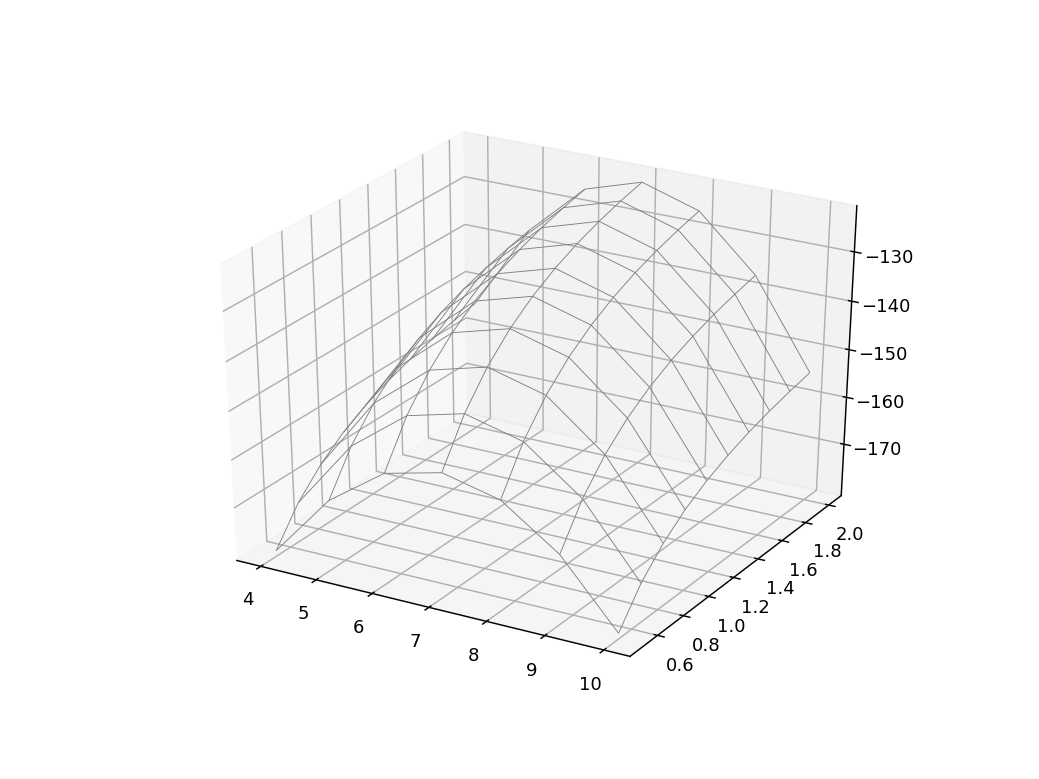

In [17]:
E_check = []
Z_check = []
for i in range(E.shape[0]):
    for j in range(E.shape[-1]):
        x = [Z_A_full[i], dR_full[j]]
        #print "(%2d,%2d,%3.1f): %s" % (Z_A_full[i], Z_B_full[i], dR_full[j], out_arr[i,i,j])
        Z_check.append(x)
        E_check.append(E[i,i,j])
E_check = np.array(E_check)
Z_check = np.array(Z_check)
dZ1 = sorted(set(Z_check[:,0]))
dR = sorted(set(Z_check[:,1]))
Xp, Yp = np.meshgrid(dZ1, dR, indexing='ij')
E_mesh = np.zeros(Xp.shape)
for s, e in enumerate(E_check):
    i = dZ1.index(Z_check[s][0])
    j = dR.index(Z_check[s][1])
    E_mesh[i,j] = e

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(Xp,Yp,E_mesh, color='0.5', linewidth=0.5)

# N2 4D surface (Z1, Z2, R, N)

## input generation

## output extraction

# Finite differece data

## Full 4D finite difference

In [19]:
import itertools

dZ = [-0.05, 0, 0.05]
dR = [-0.1, 0, 0.1]
dN = [-1, 0, 1]
mols = []
inps = []
for dz1, dz2, dr, dn in itertools.product(dZ, dZ, dR, dN):
    i, j, k, l = dZ.index(dz1), dZ.index(dz2), dR.index(dr), dN.index(dn)
    #print i,j,k,l, dz1, dz2, dr, dn, dZ[i], dZ[j], dR[k], dN[l]
    mol = qtk.Molecule()
    mol.build([[7,0,0,0], [7,1.1+dr,0,0]])
    new_Z = mol.Z + np.array([dz1, dz2])
    mol.name = mol.name + '_%d%d%d%d' % (i,j,k,l)
    if dn != 0:
        mol.setChargeMultiplicity(dn, 2)
    inp = qtk.QMInp(mol, nuclear_charges=new_Z , **qmsetting_production_ccsdt)
    inps.append(inp)
    mols.append(mol)

In [21]:
qtk.qmWriteAll(inps, 'N2_4D_diff_production', compress=True)

qmWriteAll: compression completed 


In [ ]:
outs = []
for f in sorted(glob('N2_4D_diff_production/*/*.out')):
    outs.append(qtk.QMOut(f, program='gaussian'))

In [17]:
for out in outs:
    Et = 0
    for k, v in out.energies.iteritems():
        if k != 'Enn':
            Et += v
        else:
            Et += out.molecule.nuclear_repulsion()
    out.Et = Et

In [89]:
# E = np.zeros([3,3,3,3])
# for out in outs:
#     i,j,k,l = map(int, list(os.path.splitext(out.name)[0].split('_')[1]))
#     E[i,j,k,l] = out.Et - out.nuclear_repulsion
#E = np.array(E)
#print E
#np.savez('data_N2_ccsdt_wocharge.npz', E=E, dZ=dZ)

full 4D does not converge with charged systems, use HOMO, LUMO derivatives to approximate derivatives

## 3D finite difference

## N2

In [15]:
import itertools
dZ = [-0.05, 0, 0.05]
dR = [-0.01, 0, 0.01]
# dZ = np.linspace(-1, 1, endpoint=True, num=10).tolist()
# dR = np.linspace(-0.2, 0.2, endpoint=True, num=10).tolist()
mols = []
inps = []
for dz1, dz2, dr in itertools.product(dZ, dZ, dR):
    i, j, k = dZ.index(dz1), dZ.index(dz2), dR.index(dr)
    #print i,j,k,l, dz1, dz2, dr, dn, dZ[i], dZ[j], dR[k], dN[l]
    mol = qtk.Molecule()
    mol.build([[7,0,0,0], [7,1.1+dr,0,0]])
    new_Z = mol.Z + np.array([dz1, dz2])
    mol.name = mol.name + '_%d%d%d' % (i,j,k)
#     if dn != 0:
#         mol.setChargeMultiplicity(dn, 2)
    inp = qtk.QMInp(mol, nuclear_charges=new_Z, save_density=True, **qmsetting_production_ccsdt)
    inps.append(inp)
    mols.append(mol)
#name_root = 'N2_3D_diff_ccsdt'
name_root = 'N2_3D_diff_production_dR01'

In [49]:
#qtk.qmWriteAll(inps, name_root, compress=True)

qmWriteAll: compression completed 


In [16]:
outs = []
#qtk.setting.quiet=True
for f in sorted(glob('%s/*/*.out' % name_root)):
    outs.append(qtk.QMOut(f, program='gaussian'))
#qtk.setting.quite=False

# CO

In [4]:
import itertools
dZ = [-0.05, 0, 0.05]
dR = (np.array([-0.01, 0, 0.01]) / qtk.setting.a2b).tolist()
# dZ = np.linspace(-1, 1, endpoint=True, num=10).tolist()
# dR = np.linspace(-0.2, 0.2, endpoint=True, num=10).tolist()
mols = []
inps = []
for dz1, dz2, dr in itertools.product(dZ, dZ, dR):
    i, j, k = dZ.index(dz1), dZ.index(dz2), dR.index(dr)
    #print i,j,k,l, dz1, dz2, dr, dn, dZ[i], dZ[j], dR[k], dN[l]
    mol = qtk.Molecule()
    mol.build([[6,0,0,0], [8,1.1+dr,0,0]])
    new_Z = mol.Z + np.array([dz1, dz2])
    mol.name = mol.name + '_%d%d%d' % (i,j,k)
#     if dn != 0:
#         mol.setChargeMultiplicity(dn, 2)
    inp = qtk.QMInp(mol, nuclear_charges=new_Z, save_density=True, **qmsetting_production)
    inps.append(inp)
    mols.append(mol)
name_root = 'CO_3D_diff_production_dR01a'

In [5]:
qtk.qmWriteAll(inps, name_root, compress=True)

qmWriteAll: compression completed 


In [6]:
outs = []
#qtk.setting.quiet=True
for f in sorted(glob('%s/*/*.log' % name_root)):
    outs.append(qtk.QMOut(f, program='gaussian'))
#qtk.setting.quite=False

Z2n: atomic number 5.95 is not defined
Z2n: atomic number 7.95 is not defined
Z2n: atomic number 5.95 is not defined
Z2n: atomic number 7.95 is not defined
Z2n: atomic number 5.95 is not defined
Z2n: atomic number 7.95 is not defined
Z2n: atomic number 5.95 is not defined
Z2n: atomic number 5.95 is not defined
Z2n: atomic number 5.95 is not defined
Z2n: atomic number 5.95 is not defined
Z2n: atomic number 8.05 is not defined
Z2n: atomic number 5.95 is not defined
Z2n: atomic number 8.05 is not defined
Z2n: atomic number 5.95 is not defined
Z2n: atomic number 8.05 is not defined
Z2n: atomic number 7.95 is not defined
Z2n: atomic number 7.95 is not defined
Z2n: atomic number 7.95 is not defined
Z2n: atomic number 8.05 is not defined
Z2n: atomic number 8.05 is not defined
Z2n: atomic number 8.05 is not defined
Z2n: atomic number 6.05 is not defined
Z2n: atomic number 7.95 is not defined
Z2n: atomic number 6.05 is not defined
Z2n: atomic number 7.95 is not defined
Z2n: atomic number 6.05 i

In [7]:
E = np.zeros([3,3,3])
out_arr = np.zeros([3,3,3], dtype=object)
for out in outs:
    i,j,k = map(int, list(os.path.splitext(out.name)[0].split('_')[1]))
    #print i,j,k, os.path.splitext(out.name)[0], out.energies
    E[i,j,k] = out.Et - out.nuclear_repulsion
    out_arr[i,j,k] = out
#E = np.array(E)
#print E
#np.savez('data_N2_ccsdt_wocharge.npz', E=E, dZ=dZ)

## BF

In [6]:
import itertools
dZ = [-0.05, 0, 0.05]
dR = (np.array([-0.01, 0, 0.01]) / qtk.setting.a2b).tolist()
# dZ = np.linspace(-1, 1, endpoint=True, num=10).tolist()
# dR = np.linspace(-0.2, 0.2, endpoint=True, num=10).tolist()
mols = []
inps = []
for dz1, dz2, dr in itertools.product(dZ, dZ, dR):
    i, j, k = dZ.index(dz1), dZ.index(dz2), dR.index(dr)
    #print i,j,k,l, dz1, dz2, dr, dn, dZ[i], dZ[j], dR[k], dN[l]
    mol = qtk.Molecule()
    mol.build([[5,0,0,0], [9,1.3+dr,0,0]])
    new_Z = mol.Z + np.array([dz1, dz2])
    mol.name = mol.name + '_%d%d%d' % (i,j,k)
#     if dn != 0:
#         mol.setChargeMultiplicity(dn, 2)
    inp = qtk.QMInp(mol, nuclear_charges=new_Z, save_density=True, **qmsetting_production)
    inps.append(inp)
    mols.append(mol)
name_root = 'BF_3D_diff_production_dR01a'

In [7]:
qtk.qmWriteAll(inps, name_root, compress=True)

qmWriteAll: compression completed 


In [8]:
outs = []
#qtk.setting.quiet=True
for f in sorted(glob('%s/*/*.log' % name_root)):
    outs.append(qtk.QMOut(f, program='gaussian'))
#qtk.setting.quite=False

Z2n: atomic number 4.95 is not defined
Z2n: atomic number 8.95 is not defined
Z2n: atomic number 4.95 is not defined
Z2n: atomic number 8.95 is not defined
Z2n: atomic number 4.95 is not defined
Z2n: atomic number 8.95 is not defined
Z2n: atomic number 4.95 is not defined
Z2n: atomic number 4.95 is not defined
Z2n: atomic number 4.95 is not defined
Z2n: atomic number 4.95 is not defined
Z2n: atomic number 9.05 is not defined
Z2n: atomic number 4.95 is not defined
Z2n: atomic number 9.05 is not defined
Z2n: atomic number 4.95 is not defined
Z2n: atomic number 9.05 is not defined
Z2n: atomic number 8.95 is not defined
Z2n: atomic number 8.95 is not defined
Z2n: atomic number 8.95 is not defined
Z2n: atomic number 9.05 is not defined
Z2n: atomic number 9.05 is not defined
Z2n: atomic number 9.05 is not defined
Z2n: atomic number 5.05 is not defined
Z2n: atomic number 8.95 is not defined
Z2n: atomic number 5.05 is not defined
Z2n: atomic number 8.95 is not defined
Z2n: atomic number 5.05 i

In [13]:
E = np.zeros([3,3,3])
out_arr = np.zeros([3,3,3], dtype=object)
for out in outs:
    i,j,k = map(int, list(os.path.splitext(out.name)[0].split('_')[1]))
    #print i,j,k, os.path.splitext(out.name)[0], out.energies
    E[i,j,k] = out.Et - out.nuclear_repulsion
    out_arr[i,j,k] = out
#E = np.array(E)
#print E
#np.savez('data_N2_ccsdt_wocharge.npz', E=E, dZ=dZ)
dx = np.array([dZ[-1], dZ[-1], dR[-1]])

In [14]:
dx

array([0.05      , 0.05      , 0.00529177])

In [15]:
FD_2nd(E, dx)

[2. 1. 1.]
[1. 2. 1.]
[1. 1. 2.]


(array([-11.352478  , -26.447658  ,  14.12311923]),
 array([[ -1.2368    ,   0.40773   ,   0.19322448],
        [  0.40773   ,  -2.57176   ,  -0.20938164],
        [  0.19322448,  -0.20938164, -20.23498071]]))

In [9]:
homo_i = outs[0].molecule.ne() / 2 - 1
lumo_i = homo_i + 1
dx = [0.05, 0.05, 0.01 / qtk.setting.a2b]

In [19]:
homo_i = outs[0].molecule.ne() / 2 - 1
lumo_i = homo_i + 1
E_homo = np.zeros([3,3,3])
E_lumo = np.zeros([3,3,3])
for out in outs:
    i,j,k = map(int, list(os.path.splitext(out.name)[0].split('_')[1]))
    try:
        E_homo[i,j,k] = out.mo_eigenvalues[homo_i]
        E_lumo[i,j,k] = out.mo_eigenvalues[lumo_i]
    except:
        print "failed for %d,%d,%d" % (i,j,k)

In [20]:
E_dN = (E_homo + E_lumo) / 2

In [21]:
dNN = (E_lumo[1,1,1] - E_homo[1,1,1]) / 2
print dNN

dNz1 = (E_dN[2,1,1] - E_dN[0,1,1]) / (2*dx[0])
print dNz1

dNz2 = (E_dN[1,2,1] - E_dN[1,0,1]) / (2*dx[1])
print dNz2

dNr = (E_dN[1,1,2] - E_dN[1,1,0]) / (2*dx[2])
print dNr

0.15230448935000002
-0.47163264050000014
-0.47163264050000014
-0.22265153249999975


In [7]:
E = np.zeros([3,3,3])
out_arr = np.zeros([3,3,3], dtype=object)
for out in outs:
    i,j,k = map(int, list(os.path.splitext(out.name)[0].split('_')[1]))
    #print i,j,k, os.path.splitext(out.name)[0], out.energies
    E[i,j,k] = out.Et - out.nuclear_repulsion
    out_arr[i,j,k] = out
#E = np.array(E)
#print E
#np.savez('data_N2_ccsdt_wocharge.npz', E=E, dZ=dZ)

In [11]:
FD_2nd(E, dx)

NameError: name 'dx' is not defined

In [1]:
drr = (E[1,1,2] - 2 * E[1,1,1] + E[1,1,0]) / (dx[2] ** 2)
print drr
for _i in range(3):
    i = 2 - _i
    out = out_arr[1,1,i]
    Ee1 = out.Et - out.nuclear_repulsion
    Ee2 = 0
    for key in ['Eee', 'Eext', 'Ekin', 'Ex']:
        Ee2 += out.energies[key] 
    print E[1,1,i] - Ee1,
    print E[1,1,i] - Ee2

NameError: name 'E' is not defined

In [63]:
dz1z1 = (E[2,1,1] - 2 * E[1,1,1] + E[0,1,1]) / dx[0] ** 2
print dz1z1

dz2z2 = (E[1,2,1] - 2 * E[1,1,1] + E[1,0,1]) / dx[1] ** 2
print dz2z2

drr = (E[1,1,2] - 2 * E[1,1,1] + E[1,1,0]) / dx[2] ** 2
print drr

dz1z2 = ((E[2,2,1] - E[0,2,1]) / (2*dx[0]) - (E[2,0,1] - E[0,0,1]) / (2*dx[0])) / (2*dx[1])
dz1z2_1 = ((E[2,2,1] - E[1,2,1]) / dx[0] - (E[2,1,1] - E[1,1,1]) / dx[0]) / dx[1]
print dz1z2, dz1z2_1
dz1r = ((E[2,1,2] - E[0,1,2]) / (2*dx[0]) - (E[2,1,0] - E[0,1,0]) / (2*dx[0])) / (2*dx[2])
print dz1r
dz2r = ((E[1,2,2] - E[1,0,2]) / (2*dx[1]) - (E[1,2,0] - E[1,0,0]) / (2*dx[1])) / (2*dx[2])

-1.8775600000026311
-1.8775600000026311
-33.074930069290076
0.5077700000015284 0.5127200000060839
0.28070000000468553


In [64]:
dr = (E[1,1,2] - E[1,1,0]) / (2 * dx[2])
dz1 = (E[2,1,1] - E[0,1,1]) / (2 * dx[0])
dz2 = (E[1,2,1] - E[1,0,1]) / (2 * dx[1])
np.array([dz1, dz2, dr])

array([-18.287127  , -18.287127  ,  21.34176654])

In [3]:
H_3D = np.array([
    [dz1z1, dz1z2, dz1r],
    [dz1z2, dz2z2, dz2r],
    [dz1r, dz2r, drr]
])
H_3D

NameError: name 'dz1z1' is not defined

In [117]:
H_4D = np.array([
    [dz1z1, dz1z2, dz1r, dNz1],
    [dz1z2, dz2z2, dz2r, dNz2],
    [dz1r, dz2r, drr, dNr],
    [dNz1, dNz2, dNr, dNN]
])

In [118]:
from matplotlib import pyplot as plt
%matplotlib inline

In [119]:
np.linalg.eigh(H_3D)

(array([-33.0835641 ,  -2.38533   ,  -1.36482014]),
 array([[-8.85113848e-03, -7.07106781e-01,  7.07051382e-01],
        [-8.85113848e-03,  7.07106781e-01,  7.07051382e-01],
        [ 9.99921654e-01, -5.55111512e-17,  1.25174001e-02]]))

In [125]:
w, v = np.linalg.eigh(H_4D)

In [129]:
for i in range(4):
    print v[:,i]

[-0.00875466 -0.00875466  0.99990255  0.00645014]
[ 7.07106781e-01 -7.07106781e-01  1.11022302e-16  3.33066907e-16]
[0.66139693 0.66139693 0.00930086 0.35358408]
[-0.24995492 -0.24995492 -0.01041089  0.93538051]


# H2 to Pb2

In [8]:
i,j,k,l

(2, 2, 2, 2)

In [1]:
import qctoolkit as qtk
with open('ano_gbasis_h-pb.txt') as f:
#with open('sto2g_gbasis.txt') as f:
    basis = f.readlines()

/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


missing file: mov2asc
please modify /path/to/qctoolkit/setting.py and recompile.


In [2]:
mol = qtk.Molecule()
ZR = [[82, 0,0,0], [82, 3,0,0]]
#ZR = [[1, 0,0,0], [1, 3,0,0]]
mol.build(ZR)

inp = qtk.QMInp(mol, program='gaussian', basis_set=basis)

In [48]:
#inp.run('Pb_test_2', overwrite=True)

In [4]:
inp.write()

%nproc=1
# pbepbe/gen force int(grid=ultrafine) 6d 10f Scf(xqc, maxcycle=1000,verytight) nosymm IOp(2/12=3)

Pb2

0   1
Pb   0.0000   0.0000   0.0000
Pb   3.0000   0.0000   0.0000

Pb     0 
S   25   1.00
 53286308.10000000           0.00123695       
 12563091.60000000           0.00157486       
 3649632.710000000           0.00411074       
 1155667.460000000           0.00741927       
 393662.3720000000           0.01505097       
 141880.7120000000           0.02801240       
  53715.8205000000           0.05327655       
  21155.9239000000           0.09863867       
   8592.0215100000           0.17847075       
   3587.6991100000           0.28538789       
   1543.1283500000           0.33478996       
    682.7511080000           0.19360405       
    310.8099220000           0.02521078       
    147.3366870000           0.00188799       
     72.0274889000          -0.00160778       
     36.0688738000           0.00122738       
     17.9146370000          -0.00086345    

In [5]:
qtk.n2Z('Pb')

82.0

In [85]:
np.round(3.2)

3.0